<a href="https://colab.research.google.com/github/NBK-code/Demonstrations/blob/main/CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import cv2
import PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
classifier = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=(224,224,3))])

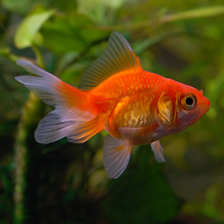

In [3]:
gold_fish = Image.open("/content/sample_data/goldfish.jpg").resize((224,224))
gold_fish

In [4]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [5]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [6]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [7]:
image_labels = []
with open("/content/sample_data/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [8]:
image_labels[predicted_label_index]

'goldfish'

In [9]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='/content/sample_data', untar=True)

228827136/228813984 [==============================] - 2s 0us/step


In [10]:
data_dir

'/content/sample_data/datasets/flower_photos'

In [19]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/sample_data/datasets/flower_photos')

In [20]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('/content/sample_data/datasets/flower_photos/dandelion/10946896405_81d2d50941_m.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/dandelion/315645471_dda66c6338_m.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/dandelion/4574736702_b15ecf97d0_m.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/dandelion/5676682203_70d797f760.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/dandelion/17574213074_f5416afd84.jpg')]

In [21]:
list(data_dir.glob('roses/*.jpg'))[:5]

[PosixPath('/content/sample_data/datasets/flower_photos/roses/3475572132_01ae28e834_n.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/3664842094_5fd60ee26b.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/1392579828_ab5a139052.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/14381787252_e8e12e277a_n.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/14747962886_2bff6bb323_m.jpg')]

In [22]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [25]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('/content/sample_data/datasets/flower_photos/roses/3475572132_01ae28e834_n.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/3664842094_5fd60ee26b.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/1392579828_ab5a139052.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/14381787252_e8e12e277a_n.jpg'),
 PosixPath('/content/sample_data/datasets/flower_photos/roses/14747962886_2bff6bb323_m.jpg')]

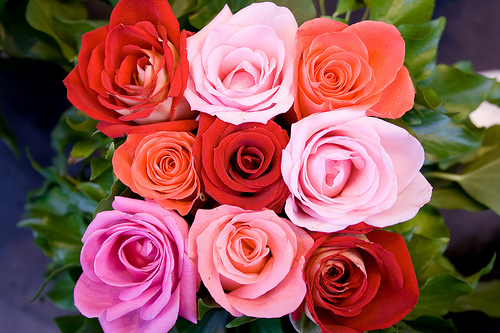

In [26]:
PIL.Image.open(str(roses[1]))

In [27]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [28]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [29]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [30]:
img.shape

(240, 320, 3)

In [31]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [32]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [33]:
X = np.array(X)
y = np.array(y)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [35]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [36]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [37]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [38]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 79s 866ms/step - loss: 0.8397 - acc: 0.6810
Epoch 2/5
86/86 [==============================] - 75s 875ms/step - loss: 0.4353 - acc: 0.8448
Epoch 3/5
86/86 [==============================] - 75s 876ms/step - loss: 0.3447 - acc: 0.8815
Epoch 4/5
86/86 [==============================] - 75s 876ms/step - loss: 0.2835 - acc: 0.9077
Epoch 5/5
86/86 [==============================] - 74s 862ms/step - loss: 0.2432 - acc: 0.9277


In [39]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 27s 874ms/step - loss: 0.3510 - acc: 0.8802


[0.3509838581085205, 0.8801742792129517]